# 对Github中星标前100的仓库数据进行可视化与分析

## 仓库信息获取

用Python与GitHub的GraphQL API交互，获取前100仓库的详细信息。发送请求提取仓库数据之后，将数据保存到 ‘top_100_repos.json’ 文件中。

In [15]:
import requests
import json

# 调用github的API来获取相关仓库的信息
GITHUB_TOKEN = ''  # 你的GitHub API令牌
API_URL = 'https://api.github.com/graphql'  # GitHub GraphQL API的URL

In [16]:
# GraphQL 查询语句
query = """
{
  search(query: "stars:>1", type: REPOSITORY, first: 100) {
    nodes {
      ... on Repository {
        name
        owner {
          login
        }
        stargazerCount
        forkCount
        watchers {
          totalCount
        }
        issues {
          totalCount
        }
        primaryLanguage {
          name
        }
        pullRequests {
          totalCount
        }
      }
    }
  }
}
"""

headers = {
    'Authorization': f'Bearer {GITHUB_TOKEN}'
}

# 发送请求
response = requests.post(API_URL, json={'query': query}, headers=headers)

# 检查响应
if response.status_code == 200:
    result = response.json()
    # 提取仓库数据
    repos = result['data']['search']['nodes']
    # 保存到JSON文件
    with open('top_100_repos.json', 'w') as f:
        json.dump(repos, f, indent=2)
    print("数据已成功保存到 top_100_repos.json 文件中")
else:
    raise Exception(f"Query failed to run by returning code of {response.status_code}. {response.text}")

数据已成功保存到 top_100_repos.json 文件中


## 指标介绍
为了分析仓库的相关数据，我们分别提取了仓库名（name），作者名（owner），星标数量（stargazerCount），fork的次数（forkCount），访问人数（watchers.totalCount），issue人数（issues.totalCount），主要使用语言（primaryLanguage.name），PR的数量(pullRequests.totalCount)等八个指标进行分析。

简单例举数据信息如下:

In [74]:
# 从json文件中读取数据
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 读取 JSON 文件
with open('top_100_repos.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

for i in range(0, 5):
    print(data[i])

{'name': 'freeCodeCamp', 'owner': {'login': 'freeCodeCamp'}, 'stargazerCount': 393284, 'forkCount': 36162, 'watchers': {'totalCount': 8512}, 'issues': {'totalCount': 18063}, 'primaryLanguage': {'name': 'TypeScript'}, 'pullRequests': {'totalCount': 36676}}
{'name': 'free-programming-books', 'owner': {'login': 'EbookFoundation'}, 'stargazerCount': 327672, 'forkCount': 60648, 'watchers': {'totalCount': 9751}, 'issues': {'totalCount': 1087}, 'primaryLanguage': None, 'pullRequests': {'totalCount': 9909}}
{'name': 'awesome', 'owner': {'login': 'sindresorhus'}, 'stargazerCount': 310345, 'forkCount': 27026, 'watchers': {'totalCount': 7696}, 'issues': {'totalCount': 336}, 'primaryLanguage': None, 'pullRequests': {'totalCount': 2035}}
{'name': 'public-apis', 'owner': {'login': 'public-apis'}, 'stargazerCount': 300758, 'forkCount': 32482, 'watchers': {'totalCount': 4128}, 'issues': {'totalCount': 606}, 'primaryLanguage': {'name': 'Python'}, 'pullRequests': {'totalCount': 3184}}
{'name': 'coding-i

## 数据转换

为了便于后续的分析与可视化，我们将从json读取的list类型数据提取转换为为dataframe的格式。

In [75]:
# 初始化空的 DataFrame
repos = pd.DataFrame(columns=['name', 'forkCount', 'stargazerCount', 'watchers_count', 'issues_count', 'primaryLanguage', 'PR_count', 'owner_name'])

# 提取数据到 DataFrame
for repo in data:
    repo_data = {
        'name': repo['name'],
        'forkCount': repo['forkCount'],
        'stargazerCount': repo['stargazerCount'],
        'watchers_count': repo['watchers']['totalCount'],
        'issues_count': repo['issues']['totalCount'],
        # 对于部分仓库没有标注主要语言设置为None来处理，后续分析时将其作为一个类型进行分析
        'primaryLanguage': repo['primaryLanguage']['name'] if repo['primaryLanguage'] else None,
        'PR_count': repo['pullRequests']['totalCount'],
        'owner_name': repo['owner']['login']
    }
    tmp_df = pd.DataFrame([repo_data])
    repos = pd.concat([repos, tmp_df], ignore_index=True)

转换后的数据如下所示：

In [76]:
repos

,name,forkCount,stargazerCount,watchers_count,issues_count,primaryLanguage,PR_count,owner_name
0,freeCodeCamp,36162,393284,8512,18063,TypeScript,36676,freeCodeCamp
1,free-programming-books,60648,327672,9751,1087,None,9909,EbookFoundation
2,awesome,27026,310345,7696,336,None,2035,sindresorhus
3,public-apis,32482,300758,4128,606,Python,3184,public-apis
4,coding-interview-university,75067,298368,8750,440,None,981,jwasham
...,...,...,...,...,...,...,...,...
95,models,45837,76796,2737,7266,Python,3802,tensorflow
96,mall,28530,76500,2232,489,Java,121,macrozheng
97,yt-dlp,6018,76488,472,7289,Python,2891,yt-dlp
98,app-ideas,9237,76297,1841,145,None,665,florinpop17


# 画图分析


## 根据指标对仓库进行排序

通过可视化仓库的关键指标，我们可以深入了解它们在开源社区中的受欢迎程度和活跃度。通过分析 fork 数量、星标数、观察者数量、问题数量和拉取请求数量等属性，我们能够全面了解这些仓库在用户和开发者中的认知和参与情况。以下的图表展示了这些指标排名靠前的仓库，展示了它们的表现和社区关注度。

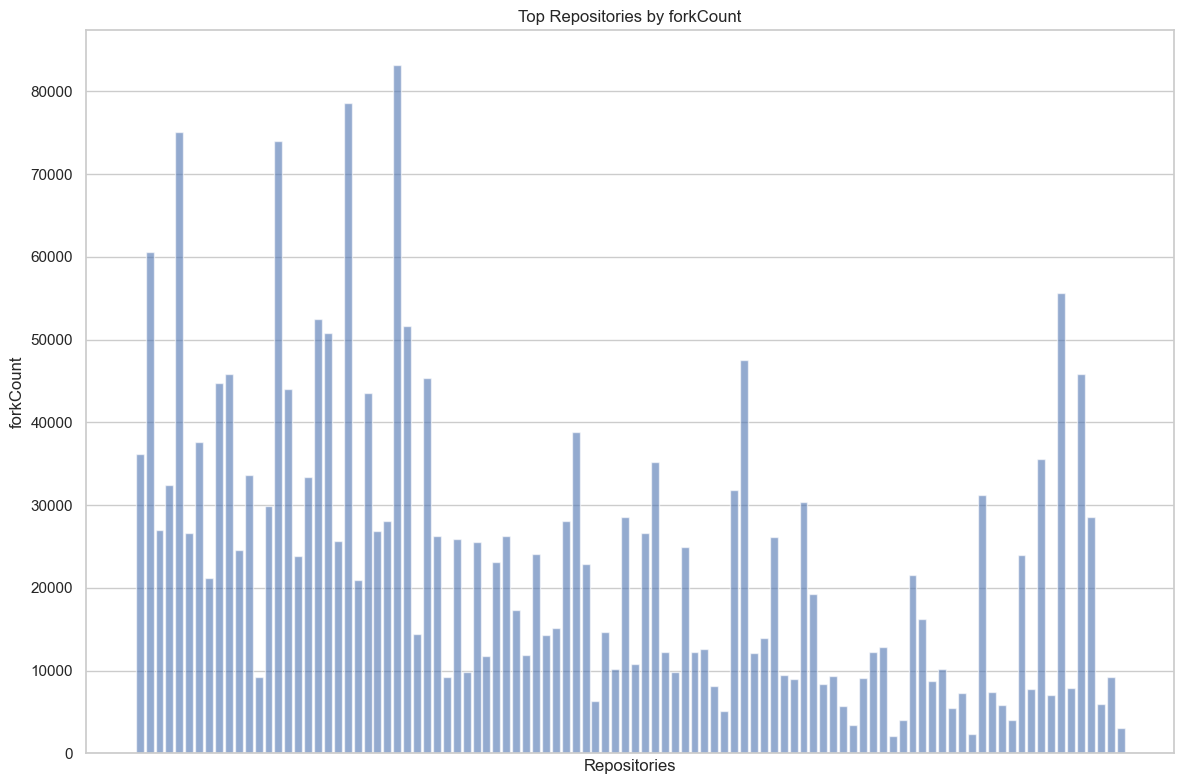

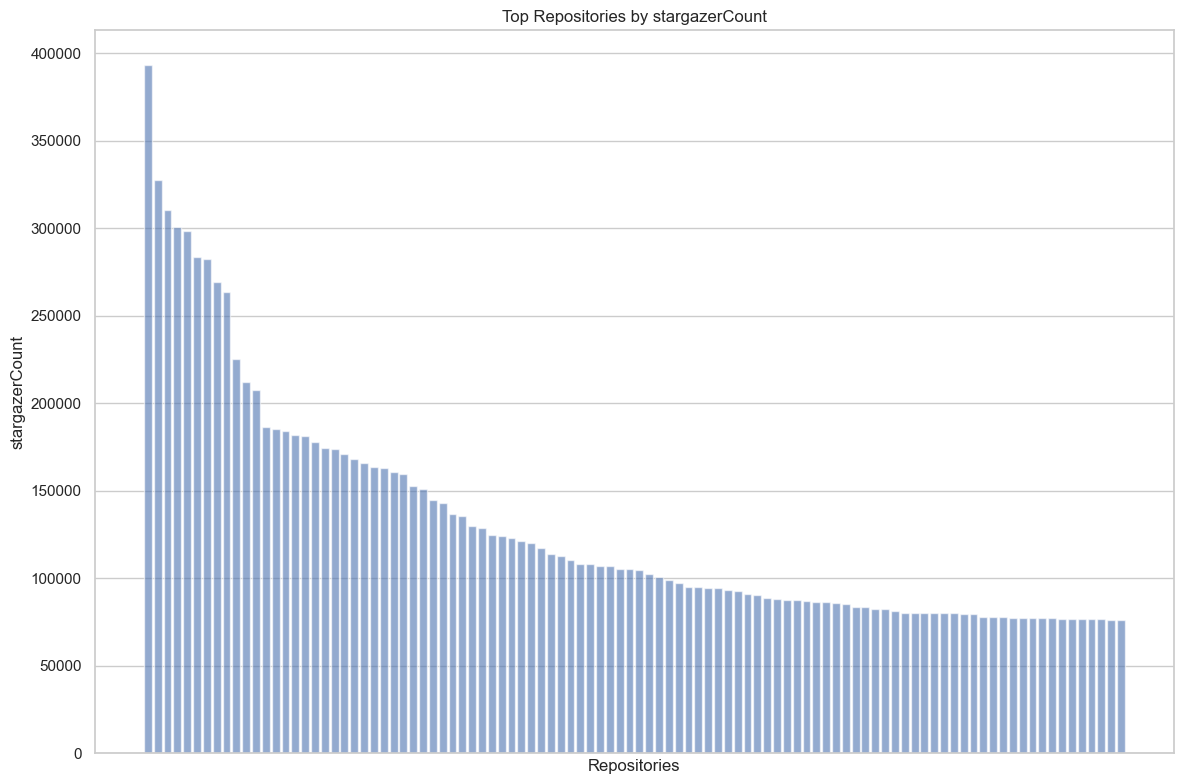

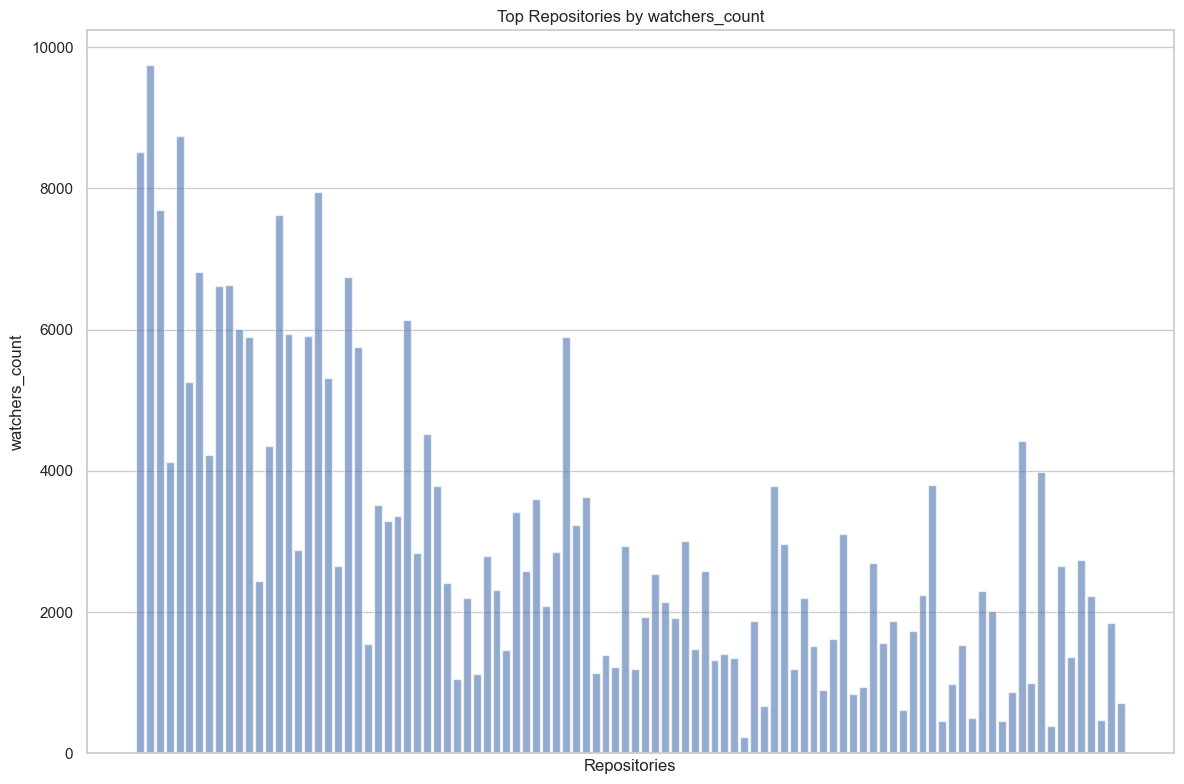

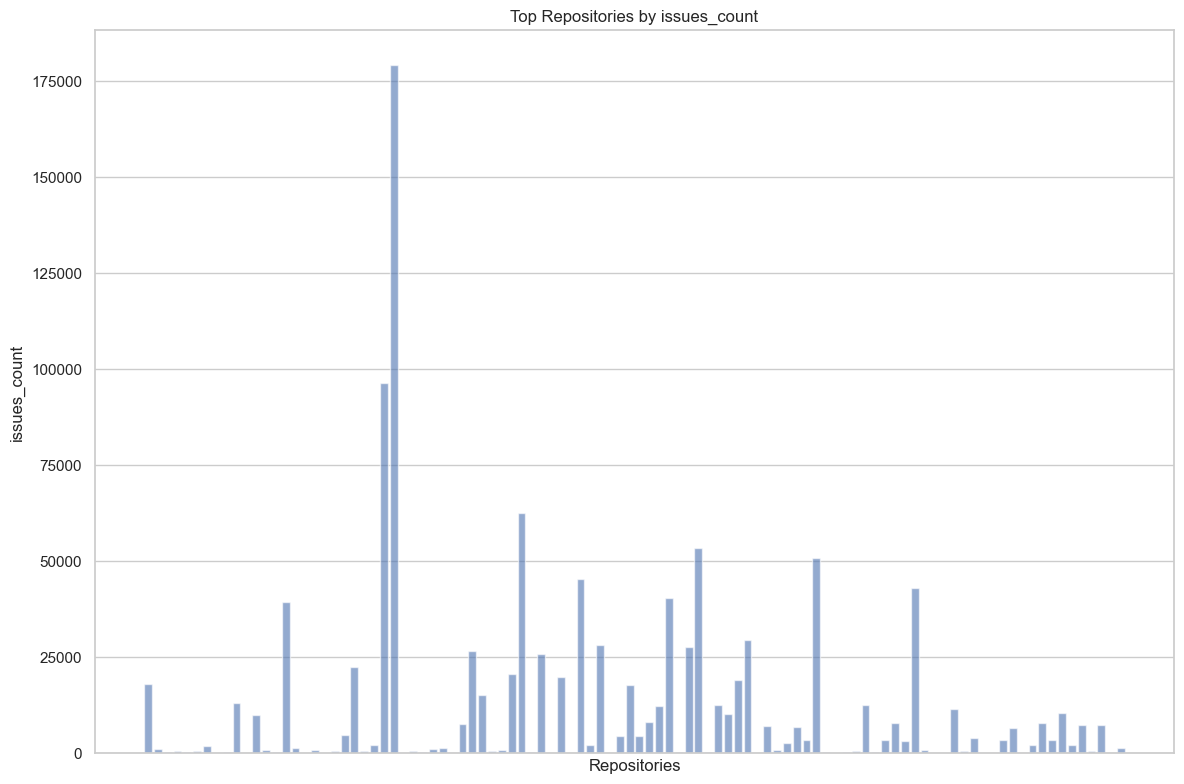

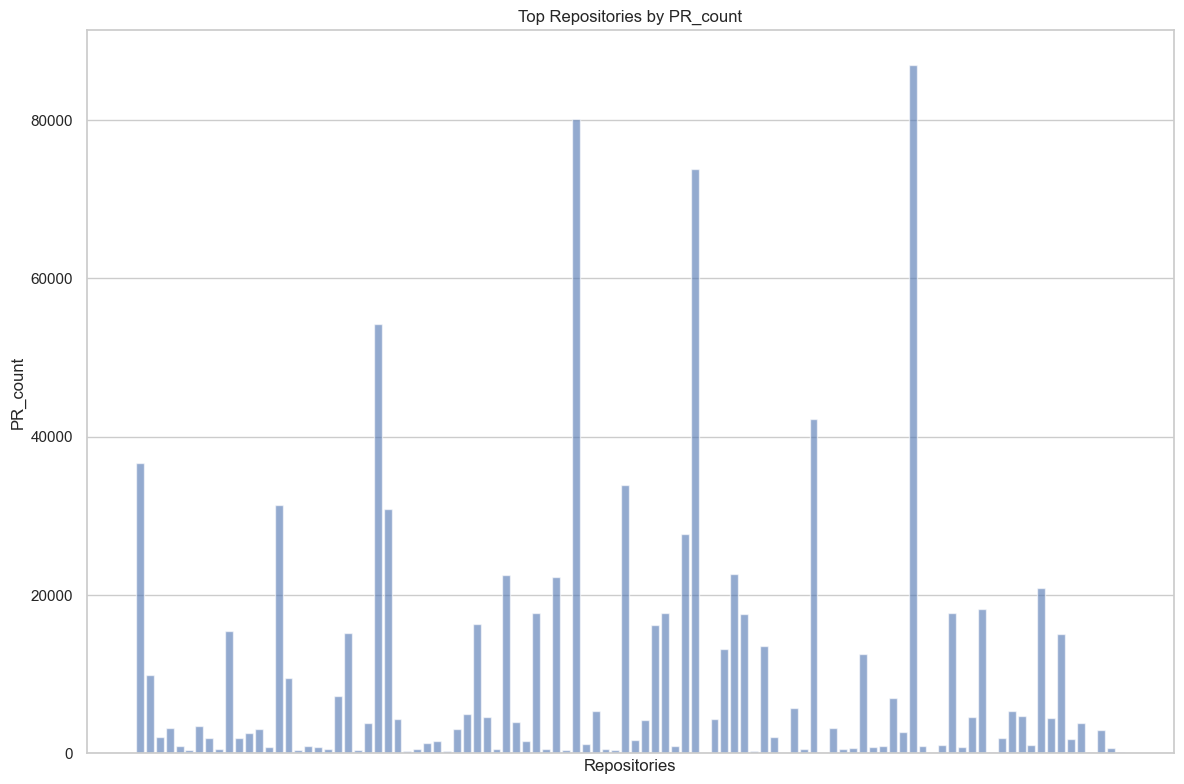

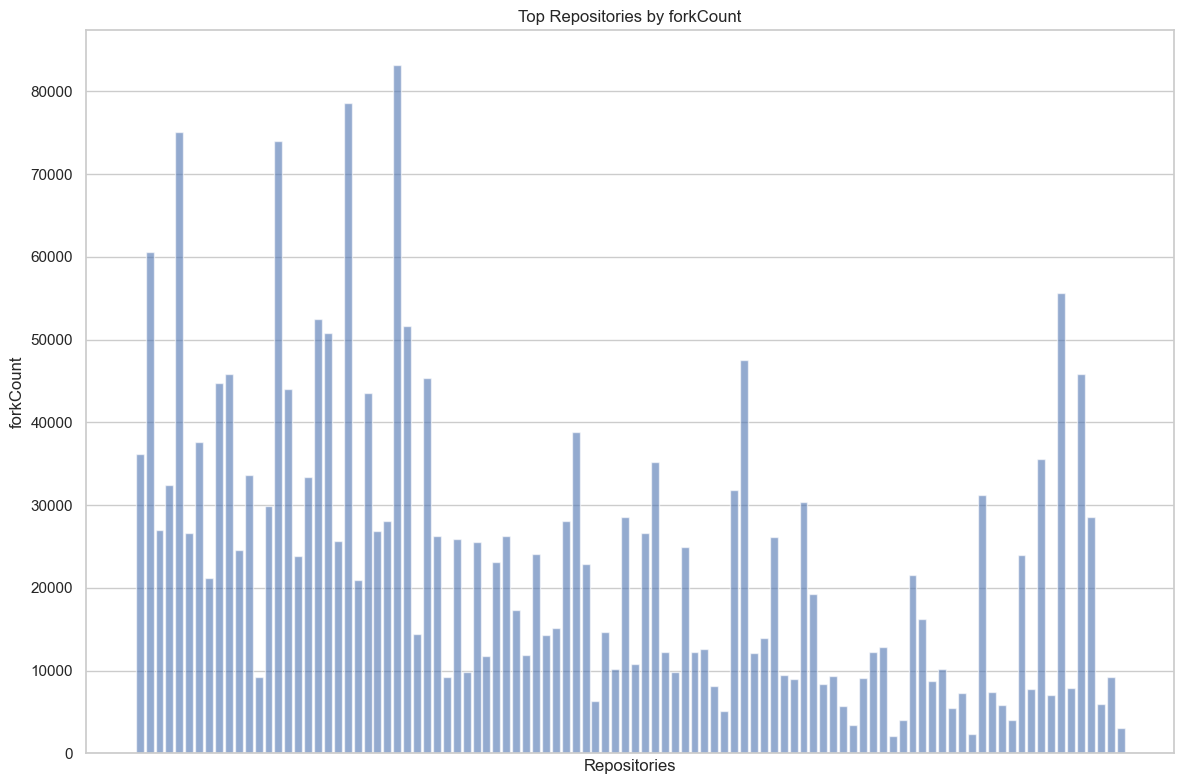

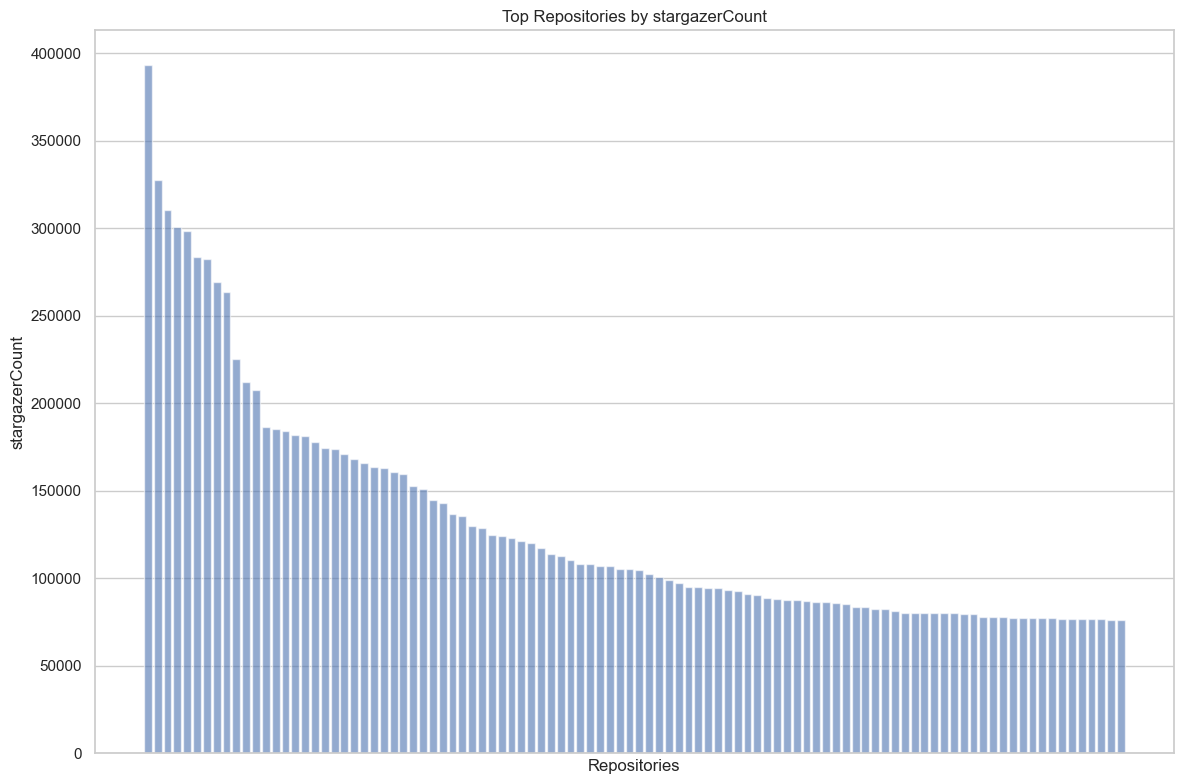

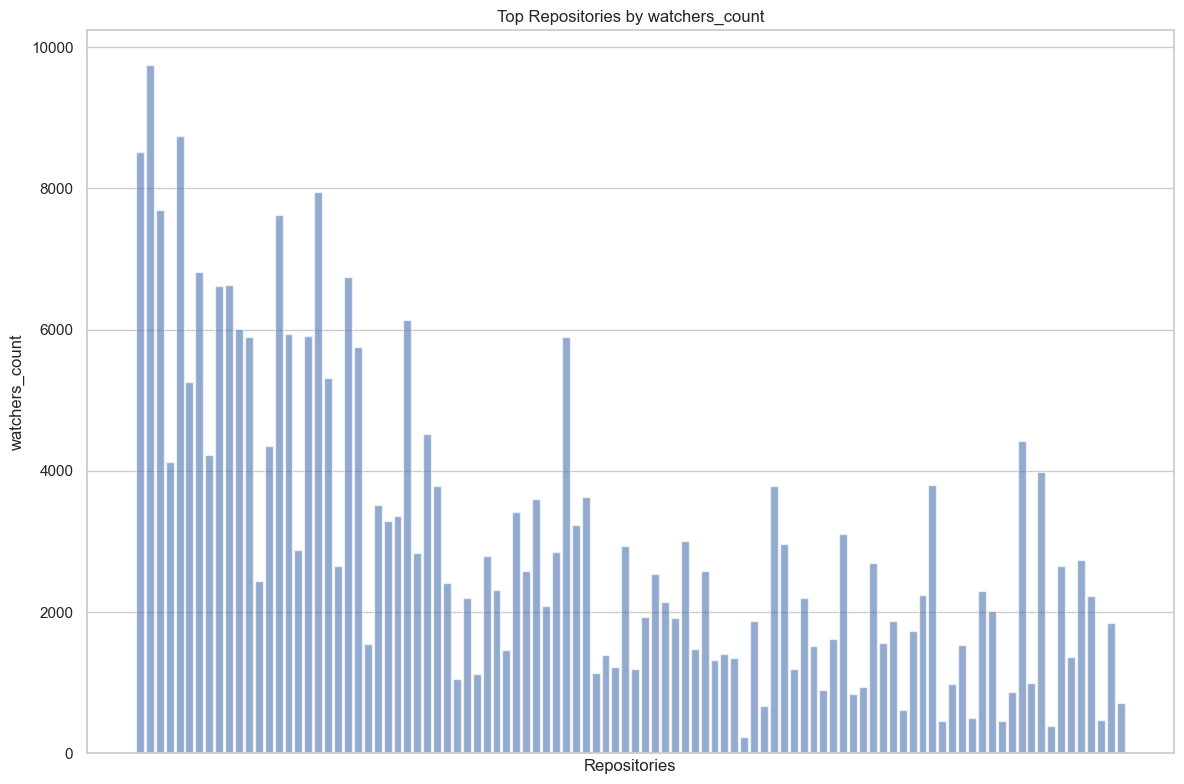

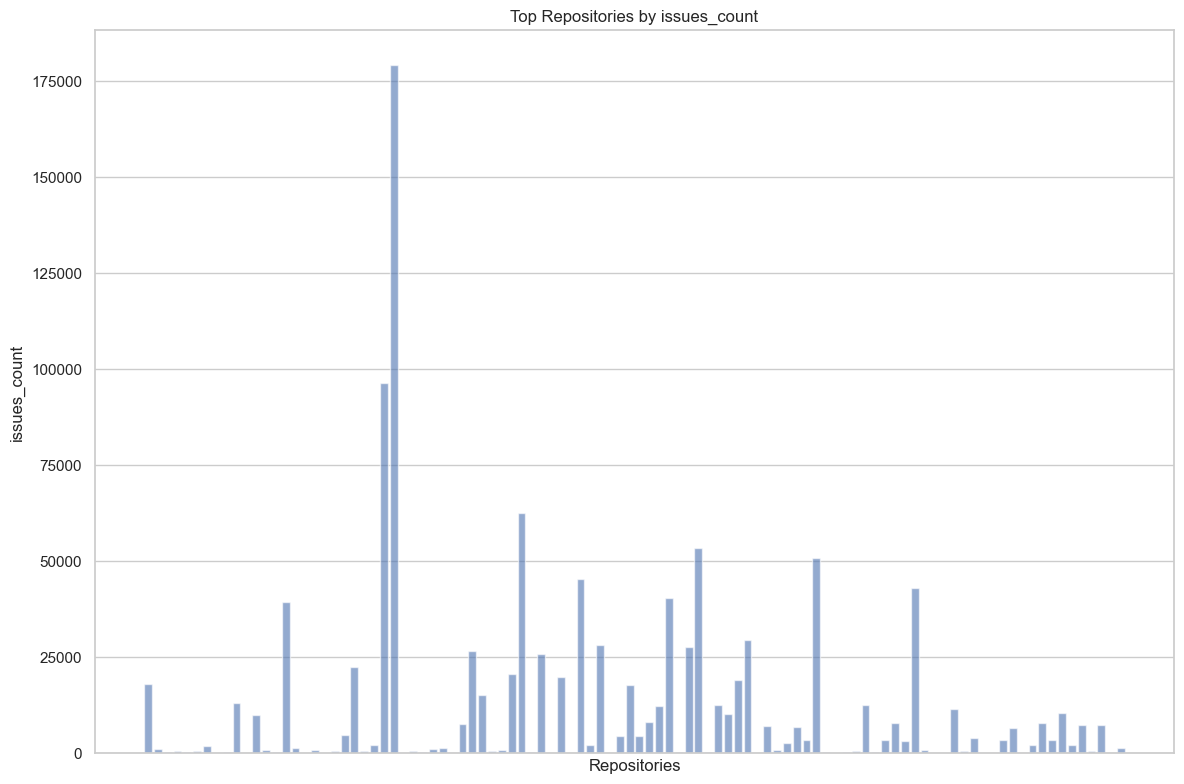

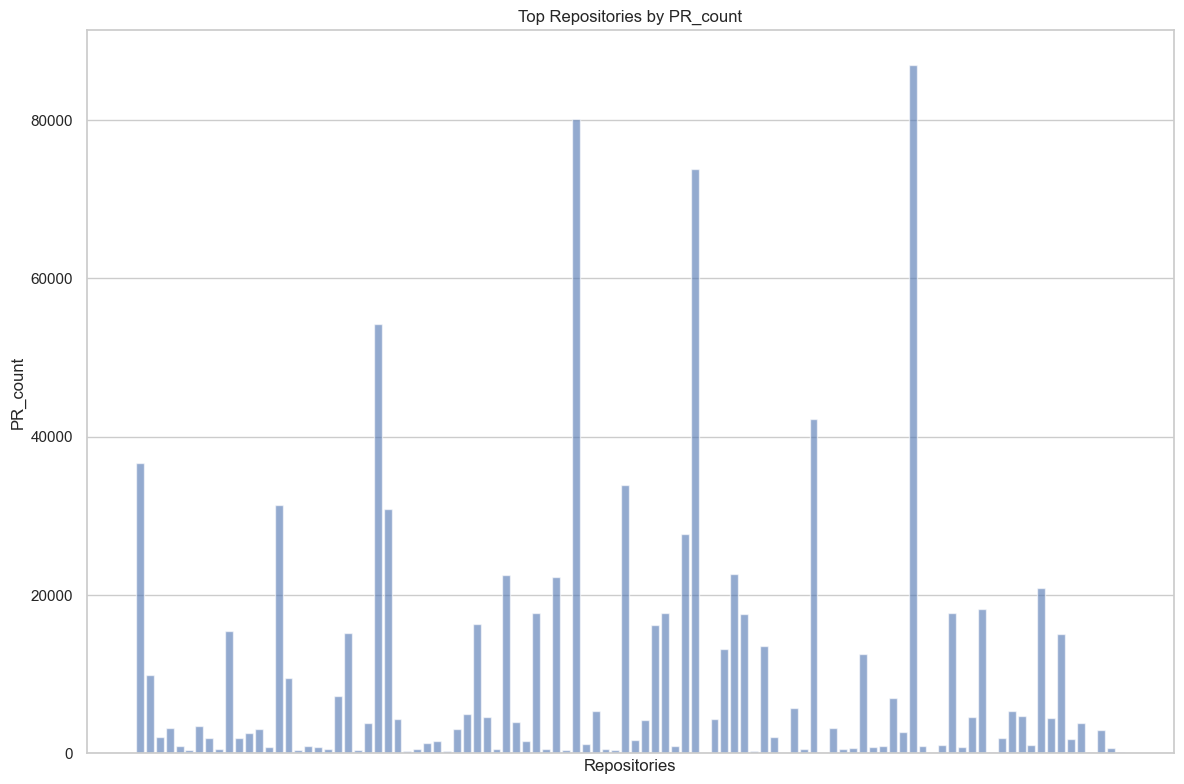

In [112]:
attributes = ['forkCount', 'stargazerCount', 'watchers_count', 'issues_count', 'PR_count']

# 绘制图表
for attribute in attributes:
    plt.figure(figsize=(12, 8))
    plt.bar(repos['name'], repos[attribute], color='b', alpha=0.6)
    plt.xticks([])
    plt.xlabel('Repositories')
    plt.ylabel(attribute)
    plt.title(f'Top Repositories by {attribute}')
    plt.tight_layout()
    plt.show()#6ECFF6'

# 绘制图表
for attribute in attributes:
    plt.figure(figsize=(12, 8))
    plt.bar(repos['name'], repos[attribute], color='b', alpha=0.6)
    plt.xticks([])
    plt.xlabel('Repositories')
    plt.ylabel(attribute)
    plt.title(f'Top Repositories by {attribute}')
    plt.tight_layout()
    plt.show()


## 对仓库主要使用的语言进行统计

当对一个仓库的主要使用语言进行统计时，通常会选择排名前十的语言进行分析和统计。这种方法能够有效地充实分析结果，因为排名靠前的语言往往代表了项目的主要开发方向和技术栈。通过这种统计，可以更好地了解项目的技术背景和开发者的偏好，为进一步的技术决策和资源分配提供有价值的参考依据。下面我们选择了前十的语言来进行统计：

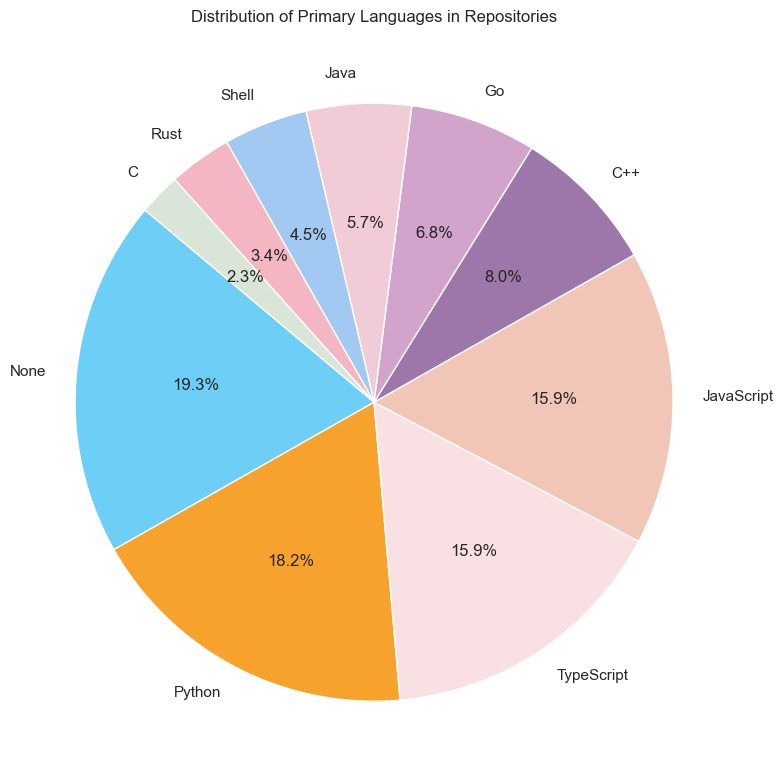

In [78]:
# 将 None 替换为 'None'，方便统计
repos['primaryLanguage'].fillna('None', inplace=True)

# 统计每种语言的数量
language_counts = repos['primaryLanguage'].value_counts()

# 如果语言种类过多，只选择前十种语言进行绘图
if len(language_counts) > 10:
    language_counts = language_counts[:10]

# 配色
macaron_palette = ['#6ECFF6', '#F7A22C', '#F9E1E3', '#F1C6B6', '#9D77AA', '#D2A4CB', '#F1CCD6', '#A1C9F1', '#F4B6C2', '#D9E5D6']
sns.set_palette(macaron_palette)

# 绘制饼图
plt.figure(figsize=(8, 8))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Primary Languages in Repositories')
plt.axis('equal')  # 保持饼图圆形
plt.tight_layout()

# 显示图表
plt.show()

## 最受欢迎的编程语言分析

通过分析GitHub上星标前100的仓库数据，我们可以揭示当前最受欢迎的编程语言以及这些python语言在开源项目中的应用情况。该可视化与分析将帮助我们深入了解开发者们的偏好及技术趋势，以及这些趋势如何影响着开源软件的发展方向和社区互动，通过数据和图表可以了解GitHub上那些引领着编程语言选择的领先项目。

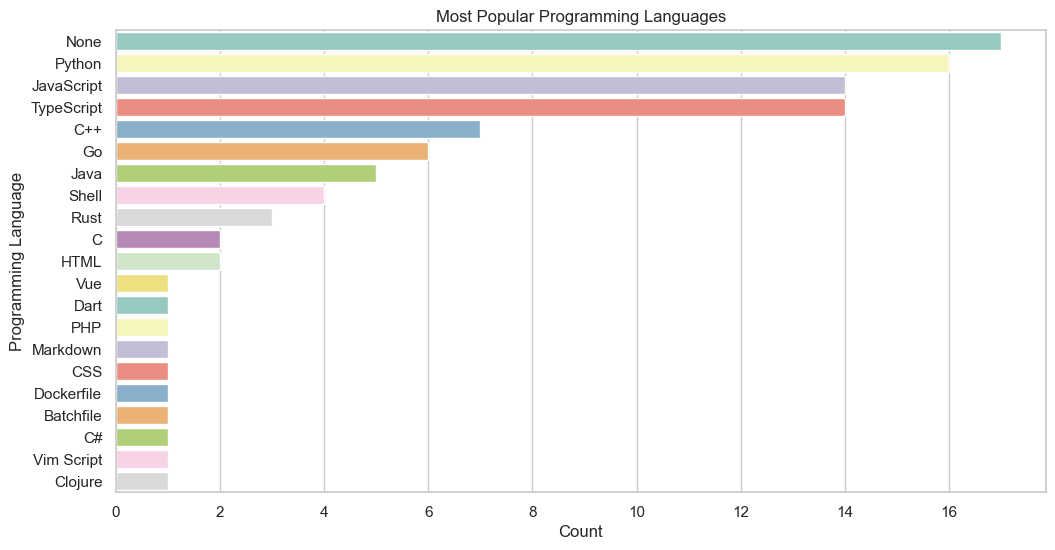

In [91]:
plt.figure(figsize=(12, 6))
sns.countplot(y='primaryLanguage', data=repos, order=repos['primaryLanguage'].value_counts().index, palette="Set3")
plt.title('Most Popular Programming Languages')
plt.xlabel('Count')
plt.ylabel('Programming Language')
plt.show()


## 按编程语言计算星标数和派生数的平均值

星标数量是衡量项目受欢迎程度的重要指标，星标数多的项目通常反映了其在开发者社区中的广泛认可和持续关注。通过分析GitHub上星标前100的仓库数据，特别是按编程语言对星标数和派生数进行平均值计算，我们可以深入了解不同编程语言在开源社区中的受欢迎程度和活跃度。

<Figure size 1200x1200 with 0 Axes>

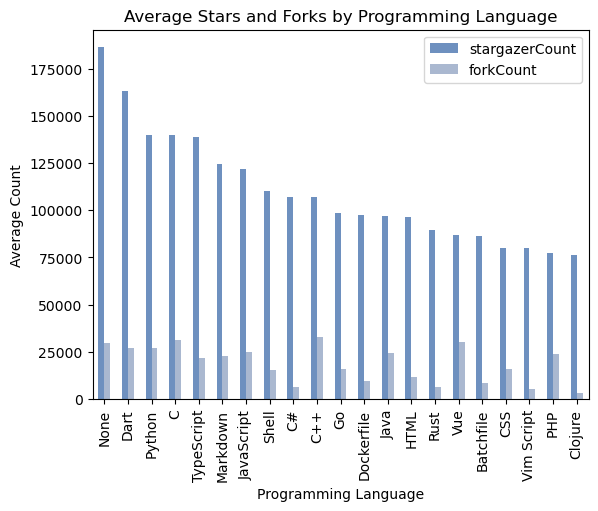

In [22]:
# 按编程语言计算星标数和派生数的平均值
language_stats = repos.groupby('primaryLanguage')[['stargazerCount', 'forkCount']].mean().sort_values(by='stargazerCount', ascending=False)

plt.figure(figsize=(12, 12))
language_stats.plot(kind='bar')
plt.title('Average Stars and Forks by Programming Language')
plt.xlabel('Programming Language')
plt.ylabel('Average Count')
plt.show()

## 可视化星标数的集中度

星标数量的集中度反映了开发者对少数热门项目的集中关注，以及大多数项目相对较少的关注程度。通过对这种集中度的分析，我们可以揭示出在开源社区中，哪些项目在吸引星标方面表现突出，以及这种分布对开源生态系统和项目发展的潜在影响。通过可视化和深入分析，我们可以了解GitHub上开源项目受欢迎程度的分布特征。

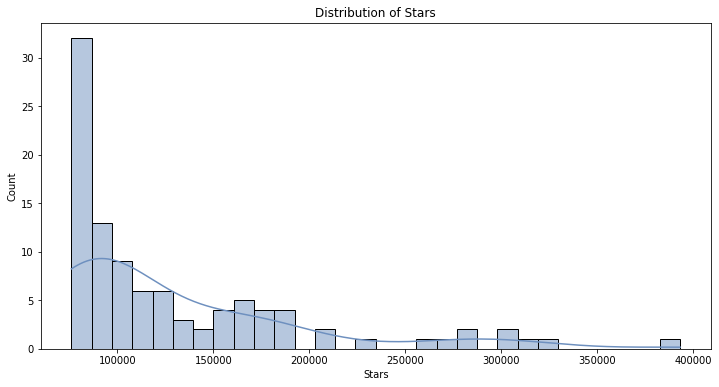

In [10]:
plt.figure(figsize=(12, 6))
sns.histplot(repos['stargazerCount'], bins=30, kde=True)
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.show()

## 联合分析

在GitHub上，星标数量和fork数量是衡量开源项目受欢迎程度和参与程度的重要指标。星标代表着对项目的关注和支持，而fork则意味着有开发者希望在项目基础上进行贡献或二次开发。

通过对星标前100的仓库数据进行可视化和分析，我们可以深入探讨这两个指标之间的关系。首先，观察整体数据，我们可以分析出不同项目之间星标数量与fork数量的比例关系。这种比例能够揭示出哪些项目不仅受到关注，而且还激发了开发者的积极参与和贡献。

进一步深入分析后，通过图我们可以看到整体的分布情况和比例最高的十个项目，这些项目显示出了在GitHub社区内受欢迎的标志。

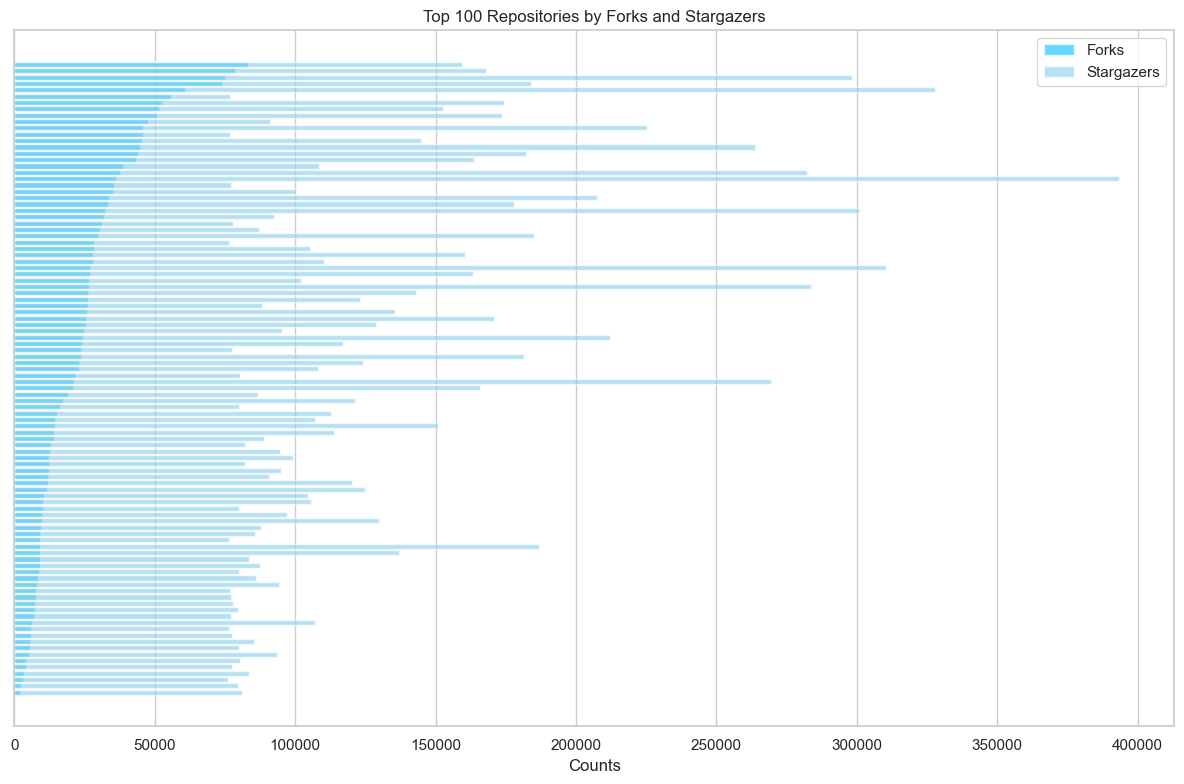

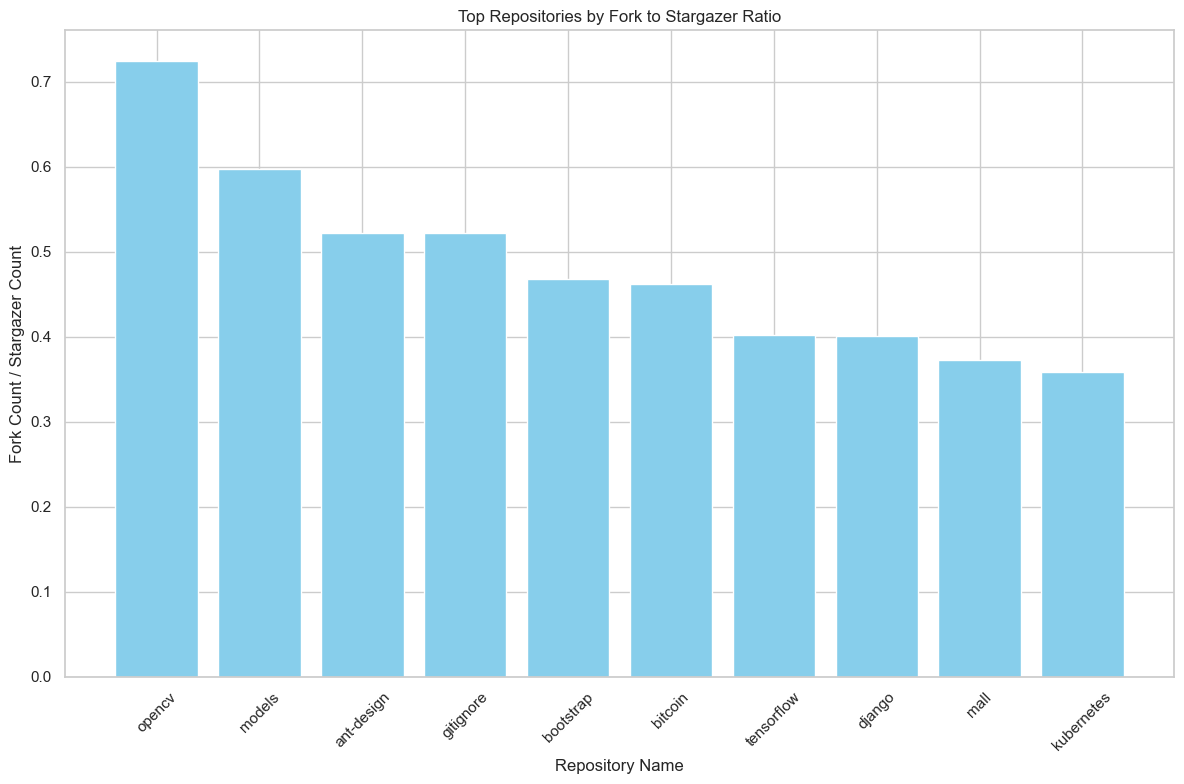

In [93]:
# 排序数据
repos = repos.sort_values(by=['forkCount', 'stargazerCount'], ascending=False)

# 绘制图表Q
plt.figure(figsize=(12, 8))
plt.barh(repos['name'], repos['forkCount'], color='deepskyblue', alpha=0.6, label='Forks')
plt.barh(repos['name'], repos['stargazerCount'], color='skyblue', alpha=0.6, label='Stargazers')
plt.yticks([])
plt.xlabel('Counts')
plt.title('Top 100 Repositories by Forks and Stargazers')
plt.legend()
plt.gca().invert_yaxis()  # 反转y轴，让最高的在顶部
plt.tight_layout()

# 显示图表
plt.show()


repos['fork_per_stargazer'] = repos['forkCount'] / repos['stargazerCount']

# 根据比值降序排序，并取前十个
top_repos = repos.sort_values(by='fork_per_stargazer', ascending=False).head(10)

# 绘制图表
plt.figure(figsize=(12, 8))
plt.bar(top_repos['name'], top_repos['fork_per_stargazer'], color='skyblue')
plt.xlabel('Repository Name')
plt.ylabel('Fork Count / Stargazer Count')
plt.title('Top Repositories by Fork to Stargazer Ratio')
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.show()

## 指标柱状图可视化

在GitHub上，星标前100的仓库数据提供了深入探索开源项目受欢迎程度和参与度的机会。通过以下代码，我们将展示并分析这些仓库在 fork 数量、stargazer 数量、pull request 数量、watcher 数量以及 issues 数量上的表现。每个柱状图将对应一个指标，我们能够比较不同仓库在这些关键指标上的表现差异。

通过这种可视化和分析，我们可以更好地理解哪些项目在GitHub社区中特别受欢迎，并探讨这些指标如何反映出项目的活跃度和社区参与势。

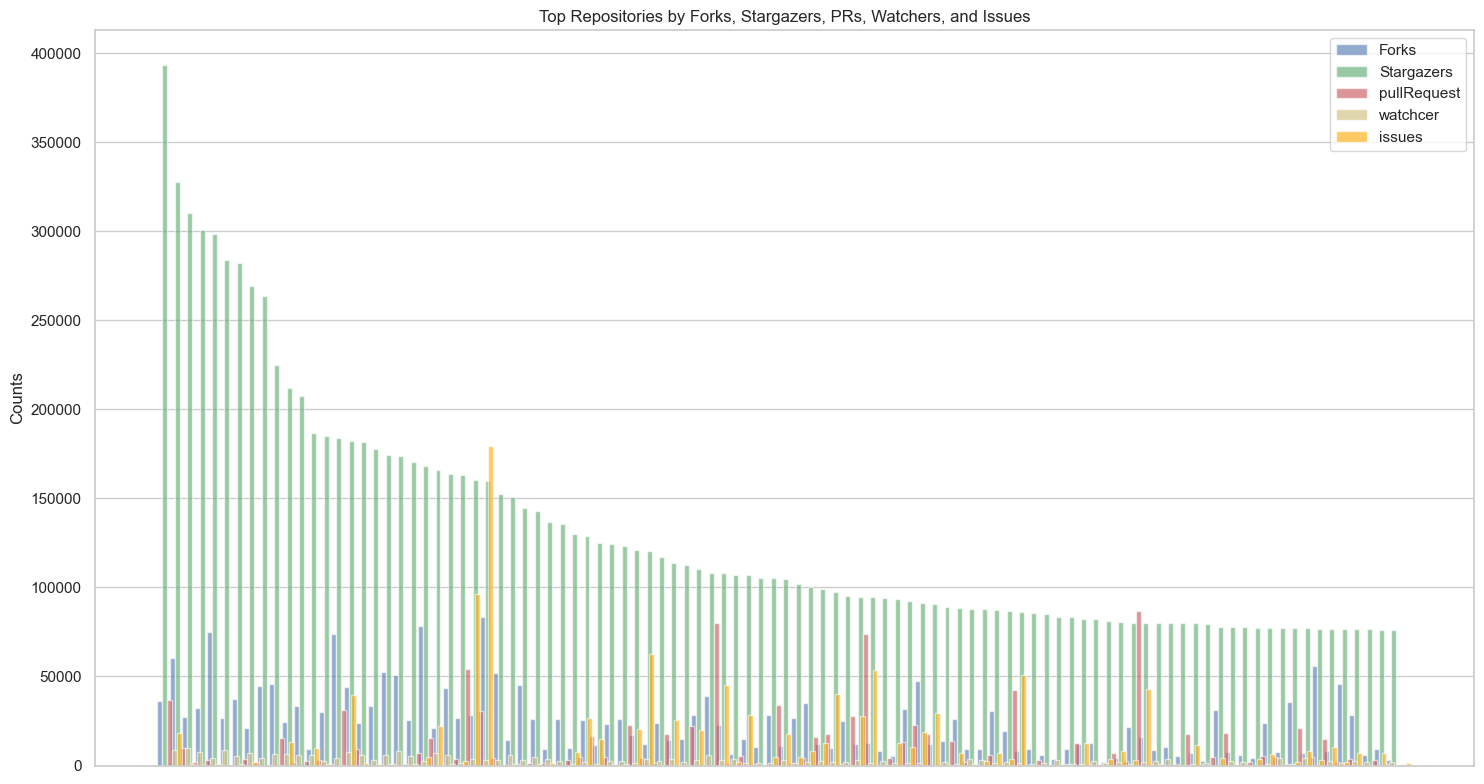

In [104]:
import numpy as np
repos = repos.sort_values(by=['stargazerCount'], ascending=False)

# 绘制图表
plt.figure(figsize=(15, 8))

bar_width = 0.4  # 每个柱状图的宽度
bar_positions = np.arange(len(repos))  # 每个仓库的位置

plt.bar(bar_positions, repos['forkCount'], width=bar_width, color='b', alpha=0.6, label='Forks')
plt.bar(bar_positions + bar_width, repos['stargazerCount'], width=bar_width, color='g', alpha=0.6, label='Stargazers')
plt.bar(bar_positions + 2 * bar_width, repos['PR_count'], width=bar_width, color='r', alpha=0.6, label='pullRequest')
plt.bar(bar_positions + 3 * bar_width, repos['watchers_count'], width=bar_width, color='y', alpha=0.6, label='watchcer')
plt.bar(bar_positions + 4 * bar_width, repos['issues_count'], width=bar_width, color='orange', alpha=0.6, label='issues')

# 设置X轴刻度及标签
plt.xticks([])
plt.ylabel('Counts')
plt.title('Top Repositories by Forks, Stargazers, PRs, Watchers, and Issues')
plt.legend()

plt.tight_layout()
plt.show()

## 散点图分析

在GitHub上，星标前100的仓库数据提供了深入了解开源项目特性的机会。通过以下散点图的分析，我们关注于探索仓库的 issues（问题）数量与 pull request（PR）数量之间的关系，同时考虑到每个项目的 fork（派生）次数作为散点的大小标识，以及主要使用语言作为分类和颜色标识。散点图展示了每个项目在 issues 和 PR 数量上的分布情况，不同颜色代表了不同的编程语言。散点的大小则反映了项目的派生次数，越大的点表示派生次数越多，在下图中可以看出C++语言的派生次数最多。

通过这种可视化，我们可以观察到以下几点趋势和关系：关注度与贡献度关系，项目的 issues 数量和 PR 数量之间的分布如何，可以揭示出项目的开发活跃度和社区参与度，例如，issues 数量较多但 PR 数量较少的项目可能需要更多的社区贡献者来解决问题；编程语言的影响：不同编程语言的项目在 issues 和 PR 数量上是否存在明显的差异或偏好，可以反映出不同技术社区的工作风格和开发模式；派生次数的角色：项目派生次数越多可能意味着它们在社区中的影响力和可扩展性较高，这些派生对整体开源生态系统的贡献也可能有所不同。

通过这些分析，我们能更深入地理解GitHub上热门项目的特征及其在开源社区中的角色与影响，从而为未来的开发和社区参与提供指导和启示。

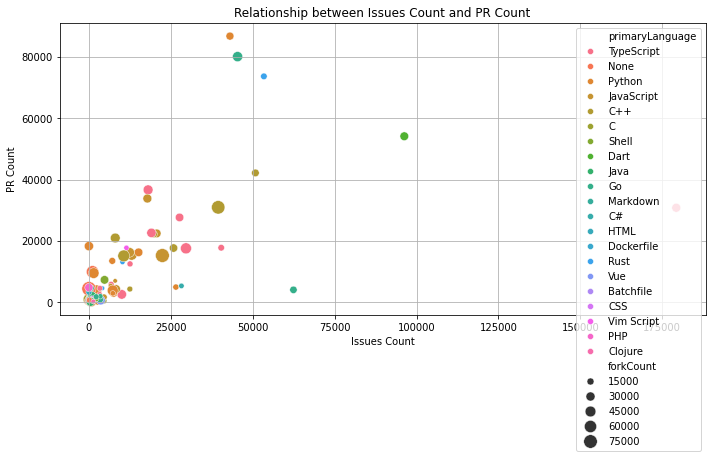

In [14]:
# 散点大小为fork的次数，X轴为issue（问题）次数，Y轴为PR的次数，以主要使用语言进行分类，不同颜色代表不同的主要使用语言对应项目的总和
plt.figure(figsize=(10, 6))
sns.scatterplot(x='issues_count', y='PR_count', data=repos, hue='primaryLanguage', size='forkCount', sizes=(20, 200), legend='auto')
plt.title('Relationship between Issues Count and PR Count')
plt.xlabel('Issues Count')
plt.ylabel('PR Count')
plt.grid(True)
plt.tight_layout()

# 总结

对GitHub中星标前100的仓库数据进行可视化与分析是一项有趣而且富有启发性的任务。通过这个过程，我们从多个角度深入研究了这些顶级仓库，揭示了一些有趣的趋势和洞察。

首先，我们通过GitHub API获取了星标前100的仓库的详细信息，包括仓库名称、描述、星标数、派生数、主要编程语言等。这些信息为我们的分析提供了基础数据。接着，我们介绍了几个关键的指标，如星标数、派生数、主要使用的编程语言等，这些指标有助于我们理解仓库的受欢迎程度和技术栈。

在画图分析阶段，我们首先根据星标数和派生数对仓库进行了排序。这一步骤帮助我们识别出最受欢迎的仓库以及它们的影响力。其次，我们对仓库主要使用的语言进行了统计，从而揭示出当前在GitHub社区中最流行的为python编程语言。这不仅有助于开发者选择合适的技术栈，也反映了技术发展的趋势。

进一步分析最受欢迎的编程语言，我们计算了各语言在星标数和派生数上的平均值，从而评估了不同编程语言在社区中的影响力和持久性。通过可视化星标数的集中度，我们发现了仓库受欢迎程度的分布情况，了解了少数顶级仓库对整体星标数的贡献程度。

在联合分析中，我们综合考虑了多个指标，如星标数、派生数和主要编程语言，揭示了它们之间的关联性和趋势。最后，我们利用柱状图和散点图对这些数据进行了可视化，使得复杂的数据更加直观和易于理解。

总结而言，通过对GitHub星标前100仓库数据的深入分析和可视化，我们不仅深入了解了这些顶级仓库的特征和技术趋势，还揭示了开源社区的动态和编程语言的受欢迎程度。这些分析不仅对开发者和研究人员具有指导意义，也为整个技术社区提供了有价值的见解，促进了开源项目的发展和创新。

